In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


In [4]:
data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [5]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

The dataloader is compoosed of 12 batches, each of them of size 15 making a total of: 180, which is enough for storing the 179 images that we have in the positive dataset

In [6]:
print(len(dataloader))

12


In [7]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.) tensor(1.)


# Iterating over the dataloader

This is how the dataloader variable can be iterated

In [8]:
i = 0
for (img, _) in dataloader:     # This iterates over the batches of images.
    print("This is batch number ", i)
    print("The images are stored in a variable of type: ", type(img))
    print("The number of images that are contained in this batch : ", len(img), "\n")
    i = i +1

This is batch number  0
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  1
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  2
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  3
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  4
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  5
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  6
The images are stored in a variable of type:  

Function for displaying one single image

In [9]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Showing one single image of each batch

Original Images


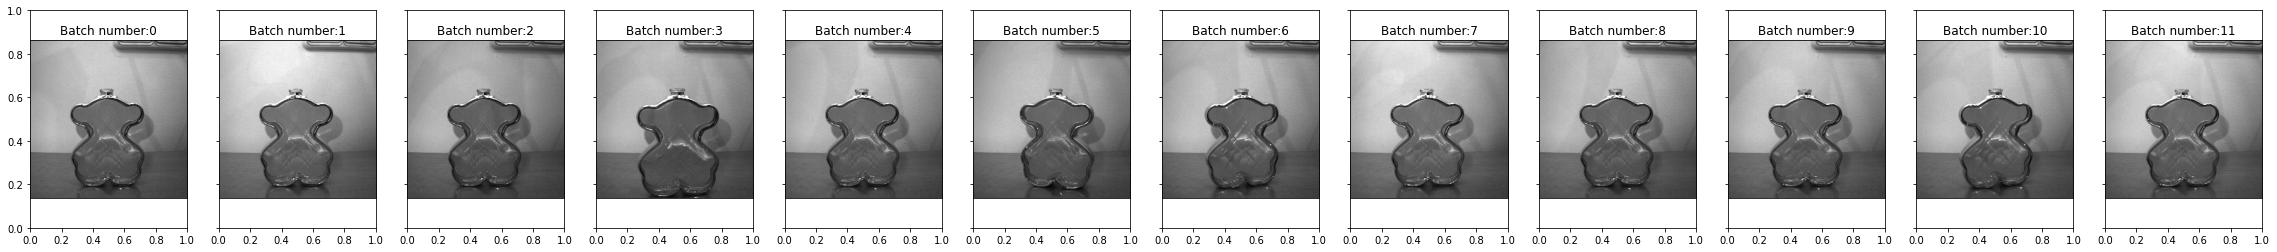

In [10]:
i = 0
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=12, sharex=True, sharey=True, figsize=(40,4))
for (img, _) in dataloader:     # This iterates over the batches of images.
    # print("This is batch number ", i)
    ax = fig.add_subplot(1, 12, i+1, xticks=[], yticks=[])
    imshow(img[i])
    ax.set_title('Batch number:'+ str(i))
    i = i +1
plt.show()
    

# Building the model Autoencoder model

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 1, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> 15, 110, 44, 44. Batch size, channel output, output image shape.
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )
        
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 1, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [12]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [13]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [14]:
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [15]:
# torch.cuda.empty_cache()

In [16]:
# # Point to training loop video
# num_epochs = 300
# outputs = []
# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs.append((epoch, img, recon))

Saving and loading a model

In [17]:
filepath = "../../../BottlesAnomalies_TFM/models/pytorchModels/PytorchModel_withCUDA"


In [18]:
# torch.save(model.state_dict(), filepath)

In [19]:
# For loading the model 
model.load_state_dict(torch.load(filepath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:


Original Images


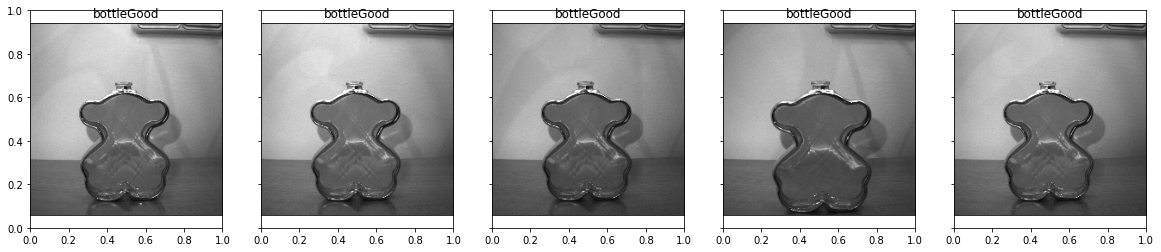

Reconstructed Images


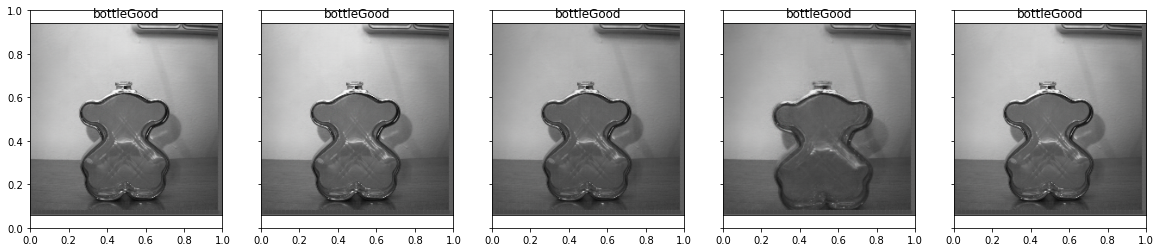

In [20]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda() # add this line for displaying the image
#Sample outputs
output = model(images)

images = images.cpu().numpy()

# output = output.view(32, 3, 224, 224)
output = output.view(15, 3, 224, 224)       # Because the batch size was changed to 15
output = output.cpu().detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
# plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

In [21]:
i = 0
for (img, _) in dataloader:     # This iterates over the batches of images.
    print("This is batch number ", i)
    print("The images are stored in a variable of type: ", type(img))
    print("The number of images that are contained in this batch : ", len(img), "\n")
    i = i +1

This is batch number  0
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  1
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  2
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  3
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  4
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  5
The images are stored in a variable of type:  <class 'torch.Tensor'>
The number of images that are contained in this batch :  15 

This is batch number  6
The images are stored in a variable of type:  

Performing the computation of the reconstruction error of all the images in the dataset. Considering the mean reconstruction error of it.

In [22]:
i = 0
result_lst = []
for (img, _) in dataloader:     # This iterates over the batches of images.
    print("This is batch number ", i)
    img = img.to(device)
    # Forward pass
    with torch.no_grad():
        Y = model(img)          
    loss = criterion(Y, img)
    # print("Loss length is: ", len(loss))
    result_lst.append( loss)     # idx of data item, err
    i = i +1
print(result_lst)

This is batch number  0
This is batch number  1
This is batch number  2
This is batch number  3
This is batch number  4
This is batch number  5
This is batch number  6
This is batch number  7
This is batch number  8
This is batch number  9
This is batch number  10
This is batch number  11
[tensor(0.0011, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0012, device='cuda:0')]


Obtaining the reconstruction error value of a single batch

In [23]:
single_rec_error = result_lst[0]
print("The type of variable of a single rec error is: ",single_rec_error)
print("The rec error value of a the first batch is: ",single_rec_error.cpu().numpy())
print("The type of the numpy converted single rec error is: ", type(single_rec_error.cpu().numpy()))

The type of variable of a single rec error is:  tensor(0.0011, device='cuda:0')
The rec error value of a the first batch is:  0.0011328693
The type of the numpy converted single rec error is:  <class 'numpy.ndarray'>


In [24]:
rec_error_list = []
for i in range(len(dataloader)):     # This iterates over the batches of images.
    rec_error_value = result_lst[i].cpu().numpy()
    rec_error_list.append(rec_error_value)     # idx of data item, err
print(rec_error_list)

[array(0.00113287, dtype=float32), array(0.00087826, dtype=float32), array(0.00090653, dtype=float32), array(0.00100919, dtype=float32), array(0.00093994, dtype=float32), array(0.00090935, dtype=float32), array(0.00093388, dtype=float32), array(0.00102261, dtype=float32), array(0.00087534, dtype=float32), array(0.0009345, dtype=float32), array(0.0008843, dtype=float32), array(0.00116191, dtype=float32)]


## Verifying if loading a new dataset with a different batch size will result in an error or not.

In [26]:
data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

In [27]:
i = 0
result_lst = []
for (img, _) in dataloader:     # This iterates over the batches of images.
    print("This is batch number ", i)
    img = img.to(device)
    # Forward pass
    with torch.no_grad():
        Y = model(img)          
    loss = criterion(Y, img)
    # print("Loss length is: ", len(loss))
    result_lst.append( loss)     # idx of data item, err
    i = i +1
print(result_lst)

This is batch number  0
This is batch number  1
This is batch number  2
This is batch number  3
This is batch number  4
This is batch number  5
[tensor(0.0009, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0009, device='cuda:0')]


From above we can see that the batch size does not matter. As we know beforehand that the model has been trained in batches of size 15, but now, we are obtaining the reconstruction errors in batches of size 32.